In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from yellowbrick.classifier import ConfusionMatrix, ClassBalance
from yellowbrick.classifier.rocauc import ROCAUC
from sklearn.model_selection import GridSearchCV

In [3]:
# import cleaned data
liver_df = pd.read_csv('indian_liver_dataset_clean.csv', index_col=0)
print(liver_df.info())

# convert variables to numeric form
liver_df.sex = liver_df.sex.map({'Male': 1, 'Female': 0})
liver_df['liver disease'] = liver_df['liver disease'].astype('int')
liver_df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 0 to 582
Data columns (total 11 columns):
age              583 non-null int64
sex              583 non-null object
total bili       583 non-null float64
direct bili      583 non-null float64
ALP              583 non-null int64
ALT              583 non-null int64
AST              583 non-null int64
total protein    583 non-null float64
albumin          583 non-null float64
a-g ratio        583 non-null float64
liver disease    583 non-null bool
dtypes: bool(1), float64(5), int64(4), object(1)
memory usage: 50.7+ KB
None


,age,sex,total bili,direct bili,ALP,ALT,AST,total protein,albumin,a-g ratio,liver disease
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1
5,46,1,1.8,0.7,208,19,14,7.6,4.4,1.30,1
6,26,0,0.9,0.2,154,16,12,7.0,3.5,1.00,1
7,29,0,0.9,0.3,202,14,11,6.7,3.6,1.10,1
8,17,1,0.9,0.3,202,22,19,7.4,4.1,1.20,0
9,55,1,0.7,0.2,290,53,58,6.8,3.4,1.00,1


In [27]:
# split into train and test, stratifying by disease group
seed = 42
test_prop = 0.2

X = liver_df.copy()
y = X.pop('liver disease')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_prop, stratify=y)

In [5]:
# create and run model
model = RandomForestClassifier(n_estimators=1000,
                               max_features='auto',
                               max_depth=None,
                               oob_score=True,
                               n_jobs=-1,
                               random_state=seed)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

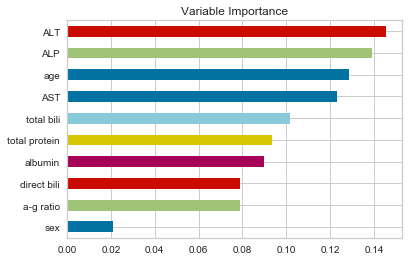

In [6]:
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.sort_values(inplace=True)
plt.title('Variable Importance')
importances.plot(kind='barh')

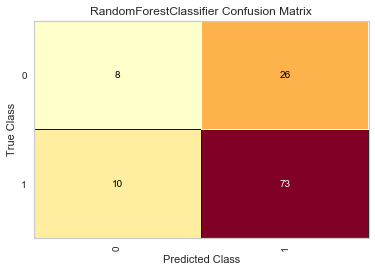

In [7]:
confusion = ConfusionMatrix(model, classes=[0,1])
confusion.score(X_test, y_test)
confusion.poof()

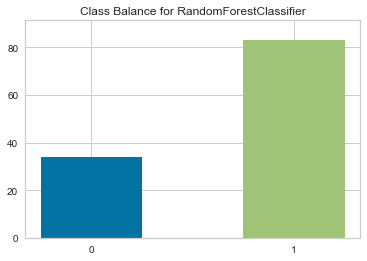

In [8]:
balance = ClassBalance(model, classes=[0,1])
plt.title('Class Balance')
balance.score(X_test, y_test)
balance.poof()

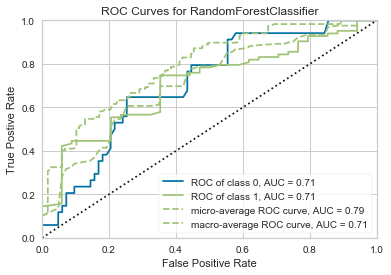

In [9]:
# ROC curve
roc_curve = ROCAUC(model, classes=[0,1])
roc_curve.score(X_test, y_test)
roc_curve.poof()

___
## Parameter Tuning

Now I will attempt to find more optimal parameters for the model. Because I have a sufficiently powerful computer for this task, I will use an exhaustive grid search strategy. For larger models with more features or observations, a random grid search may be more appropriate to limit computational expense.
___

In [20]:
# WARNING: this cell is computationally intensive - do not rerun
# optimize model parameters using exhaustive grid search, with AUC as the success metric

estimators_options = list(range(100, 1001, 100))
depth_options = [None, 10, 20, 30, 40]
leaf_options = [1, 2, 3, 4]
split_options = [2, 4, 6, 8]

param_grid = dict(n_estimators=estimators_options, 
                  max_depth=depth_options, 
                  min_samples_leaf=leaf_options, 
                  min_samples_split=split_options)

random_forest = RandomForestClassifier()

grid = GridSearchCV(random_forest, param_grid, cv=5, n_jobs=7)

grid.fit(X_train, y_train)

print(grid.best_score_)
grid.best_estimator_

0.7360515021459227


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
# optimized model
model = RandomForestClassifier(n_estimators=100,
                               max_features='auto',
                               max_depth=20,
                               min_samples_leaf=2, 
                               min_samples_split=4, 
                               n_jobs=7)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=7,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

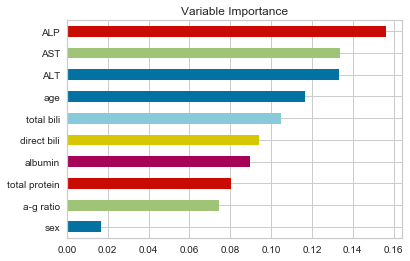

In [29]:
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.sort_values(inplace=True)
plt.title('Variable Importance')
importances.plot(kind='barh')

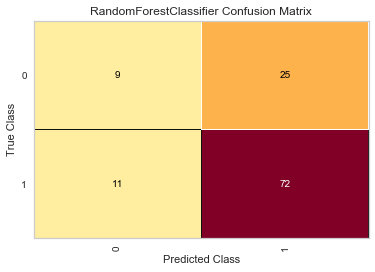

In [30]:
confusion = ConfusionMatrix(model, classes=[0,1])
confusion.score(X_test, y_test)
confusion.poof()

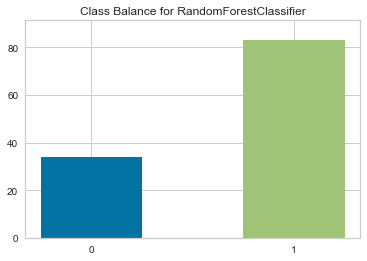

In [31]:
balance = ClassBalance(model, classes=[0,1])
plt.title('Class Balance')
balance.score(X_test, y_test)
balance.poof()

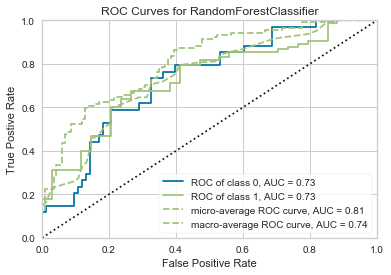

In [32]:
# ROC curve
roc_curve = ROCAUC(model, classes=[0,1])
roc_curve.score(X_test, y_test)
roc_curve.poof()

___
## Threshold Selection

Now that the model parameters have been tuned, the final step is to select a threshold for converting the model probabilities into class determinations. I have found it easiest here to visualize the sensitivity, specificity, and accuracy across a range of thresholds.
___

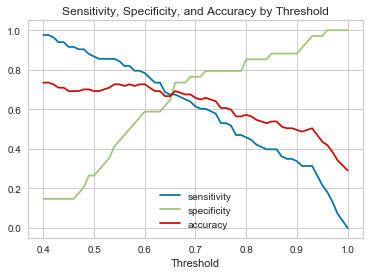

           sensitivity  specificity  accuracy
threshold                                    
0.40          0.975904     0.147059  0.735043
0.41          0.975904     0.147059  0.735043
0.42          0.963855     0.147059  0.726496
0.43          0.939759     0.147059  0.709402
0.44          0.939759     0.147059  0.709402
0.45          0.915663     0.147059  0.692308
0.46          0.915663     0.147059  0.692308
0.47          0.903614     0.176471  0.692308
0.48          0.903614     0.205882  0.700855
0.49          0.879518     0.264706  0.700855
0.50          0.867470     0.264706  0.692308
0.51          0.855422     0.294118  0.692308
0.52          0.855422     0.323529  0.700855
0.53          0.855422     0.352941  0.709402
0.54          0.855422     0.411765  0.726496
0.55          0.843373     0.441176  0.726496
0.56          0.819277     0.470588  0.717949
0.57          0.819277     0.500000  0.726496
0.58          0.795181     0.529412  0.717949
0.59          0.795181     0.55882

In [33]:
# plot model success metrics by threshold
from sklearn.metrics import confusion_matrix

def threshold_func_gen(threshold):
    ''' creates a thresholding function to convert probabilities to class designation '''
    def threshold_func(value):
        if value >= threshold:
            return 1
        else:
            return 0
    
    return threshold_func

predicted_probs = pd.Series(model.predict_proba(X_test)[:,1])
threshold_options = list(np.linspace(0.4, 1.0, num=61))
sens_by_thresh = np.empty(len(threshold_options))
spec_by_thresh = np.empty(len(threshold_options))
acc_by_thresh = np.empty(len(threshold_options))

for i, threshold in enumerate(threshold_options):
    threshold_func = threshold_func_gen(threshold)
    y_pred = predicted_probs.map(threshold_func)
    matrix = confusion_matrix(y_test, y_pred)
    sens_by_thresh[i] = matrix[1, 1]/np.sum(matrix[1,:])
    spec_by_thresh[i] = matrix[0, 0]/np.sum(matrix[0,:])
    acc_by_thresh[i] = (matrix[0,0] + matrix[1,1])/np.sum(matrix)
    
threshold_df = pd.DataFrame(threshold_options)
threshold_df['sensitivity'] = sens_by_thresh
threshold_df['specificity'] = spec_by_thresh
threshold_df['accuracy'] = acc_by_thresh
threshold_df.set_index(0, inplace=True)
threshold_df.index.name = 'threshold'
threshold_df.plot()
plt.title('Sensitivity, Specificity, and Accuracy by Threshold')
plt.xlabel('Threshold')
plt.show()
print(threshold_df)

___
Which threshold to choose is mainly a question of how the model will be used in the real world. Because the blood tests used to train this model have relatively low sensitivity for liver disease while having good specificity above a certain threshold, an argument can be made to use this model as a 'rule-in' test. In other words, if the model predicts that a person has liver disease, doctors can take that as strong indication that liver disease does, in fact, exist. For this type of model, a high threshold such as 0.76 should be selected. This threshold will only detect around 50% of liver disease patients, but has a false positive rate of less than 4%.
___

In [53]:
# show confusion matrix for threshold of 0.76
threshold_func = threshold_func_gen(0.85)
y_pred = predicted_probs.map(threshold_func)
print(confusion_matrix(y_test, y_pred))

[[30  0]
 [53 34]]


___
If maximum accuracy is desired, a threshold around 0.68 should be selected. This threshold has a good balance of sensitivity and specificity, and has the highest overall accuracy.
___

In [ ]:
# show confusion matrix for threshold of 0.68
threshold_func = threshold_func_gen(0.68)
y_pred = predicted_probs.map(threshold_func)
print(confusion_matrix(y_test, y_pred))

___
It is important to note that trying to use this model as a 'rule-out' test, or a test that has high sensitivity, is misguided due to the limitations of the measurements used to train the model. Since the blood tests have low sensitivity (many liver disease patients have normal or near-normal liver enzyme tests), this model will also have poor sensitivity.

A third option is to have the model report both the patient's predicted liver disease state using the maximal-accuracy threshold, and also the sensitivity and/or specificity corresponding to the predicted probability determined by the model. 

For example, a patient with a predicted probability of 0.80 would be predicted to have liver disease, and the model would also tell the doctor that the specificity of the model's determination is 0.92. The doctor can be relatively confident that the patient does have liver disease, because he or she knows that there is only around an 8% chance that a healthy patient would be wrongly classified as diseased with this predicted probability.

For another example, a patient with a predicted probability of 0.5 would be predicted to not have liver disease, and the model would report a sensitivity of 0.94 for its determination. The doctor could then appreciate that around 6% of people with liver disease are wrongly classified as healthy at this predicted probability.

For this kind of reporting, it would be optimal to have a meaningful measurement of predictive value. Positive predictive value is the proportion of people classified as diseased that are actually diseased, while negative predictive value is the proportion of people classified as not diseased that actually don't have disease. If these metrics could be reported accurately, it would give doctors a better estimate for the true probability that a given patient has liver disease, based on reported class determination and positive or negative predictive value.

However, in order for the predictive value of a model to have real-world significance, the class balance in the data used to train the model would have to match the true class balance in the population. Since this data set certainly does not fit that requirement, use of predictive value here would be misleading.
___